In [1]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.label_maps import CLASS_DICT
from user_constants import DATA_PATH_DICT
%matplotlib inline

In [20]:
# Constants
DATA = 'ImageNet' # Choices: ['CIFAR', 'ImageNet']
BATCH_SIZE = 10
NUM_WORKERS = 8
NUM_CLASSES_VIS = 5

DATA_SHAPE = 32 if DATA == 'CIFAR' else 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)
CLASSES = CLASS_DICT[DATA] # Class names for dataset
NUM_CLASSES = len(CLASSES) - 1 
NUM_CLASSES_VIS = min(NUM_CLASSES_VIS, NUM_CLASSES)
GRAIN = 4 if DATA != 'CIFAR' else 1

In [21]:
# Load dataset
dataset_function = getattr(datasets, DATA)
print(dataset_function)
dataset = dataset_function(DATA_PATH_DICT[DATA])
print("loading")
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS, 
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)
print("loading3 ")
data_iterator = enumerate(test_loader)
print("done")

<class 'robustness.datasets.ImageNet'>
loading
==> Preparing dataset imagenet..
loading3 
done


In [22]:
print(test_loader)

In [23]:
# Load model
# DATA1='ImageNet'
model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': f'./models/{DATA}.pt'
}

model, _ = model_utils.make_and_restore_model(**model_kwargs)
model.eval()

=> loading checkpoint './models/ImageNet.pt'
=> loaded checkpoint './models/ImageNet.pt' (epoch 105)


DataParallel(
  (module): AttackerModel(
    (normalizer): InputNormalize()
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): SequentialWithArgs(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [24]:
def downsample(x, step=GRAIN):
    down = ch.zeros([len(x), 3, DATA_SHAPE//step, DATA_SHAPE//step])

    for i in range(0, DATA_SHAPE, step):
        for j in range(0, DATA_SHAPE, step):
            v = x[:, :, i:i+step, j:j+step].mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            ii, jj = i // step, j // step
            down[:, :, ii:ii+1, jj:jj+1] = v
    return down

def upsample(x, step=GRAIN):
    up = ch.zeros([len(x), 3, DATA_SHAPE, DATA_SHAPE])

    for i in range(0, DATA_SHAPE, step):
        for j in range(0, DATA_SHAPE, step):
            ii, jj = i // step, j // step
            up[:, :, i:i+step, j:j+step] = x[:, :, ii:ii+1, jj:jj+1]
    return up

In [ ]:
# Get seed distribution (can be memory intensive to do all ImageNet classes at once)
im_test, targ_test = [], []
for _, (im, targ) in enumerate(test_loader):
#     print(targ)
    im_test.append(im)
    targ_test.append(targ)
print(len(im_test))
print(len(targ_test))

In [ ]:
im_test, targ_test = [], []
for _, (im, targ) in enumerate(test_loader):
    im_test.append(im)
    targ_test.append(targ)
    print("done append")
im_test, targ_test = ch.cat(im_test), ch.cat(targ_test)

done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done append
done

In [ ]:


conditionals = []
for i in tqdm(range(NUM_CLASSES_VIS)):
    imc = im_test[targ_test == i]
    down_flat = downsample(imc).view(len(imc), -1)
    mean = down_flat.mean(dim=0)
    down_flat = down_flat - mean.unsqueeze(dim=0)
    cov = down_flat.t() @ down_flat / len(imc)
    dist = MultivariateNormal(mean, covariance_matrix=cov+1e-4*ch.eye(3 * DATA_SHAPE//GRAIN * DATA_SHAPE//GRAIN))
    conditionals.append(dist)

In [ ]:
# Visualize seeds
img_seed = ch.stack([conditionals[i].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
                     for i in range(NUM_CLASSES_VIS)])
img_seed = ch.clamp(img_seed, min=0, max=1)
print(img_seed)
show_image_row([img_seed.cpu()], tlist=[[f'Class {i}' for i in range(NUM_CLASSES_VIS)]])

In [8]:
def generation_loss(mod, inp, targ):
    op = mod(inp)
    loss = ch.nn.CrossEntropyLoss(reduction='none')(op, targ)
    return loss, None

kwargs = {
        'custom_loss': generation_loss,
        'constraint':'2',
        'eps': 40,
        'step_size': 1,
        'iterations': 60,
        'targeted': True,
}  
    
if DATA == 'CIFAR':
    kwargs['eps'] = 30
    kwargs['step_size'] = 0.5
    kwargs['iterations'] = 60

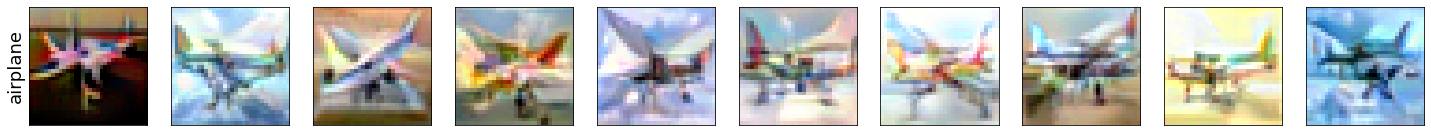

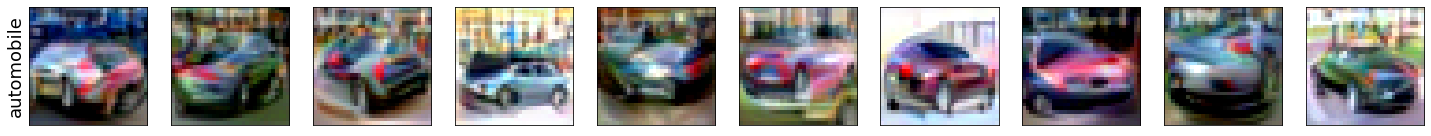

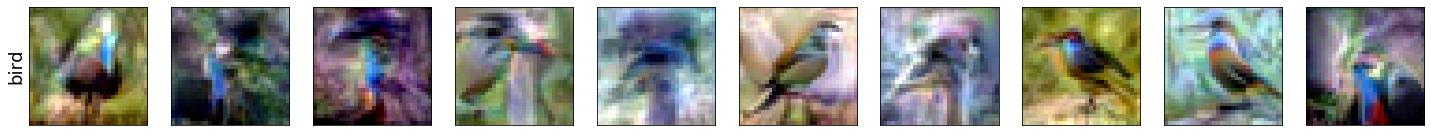

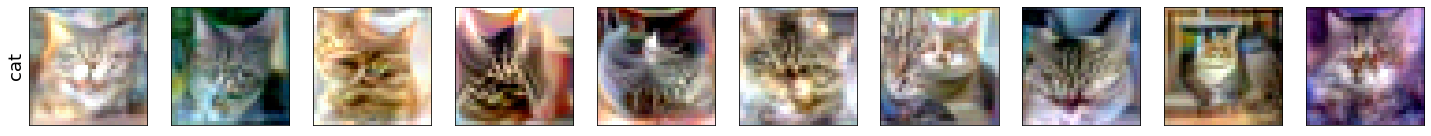

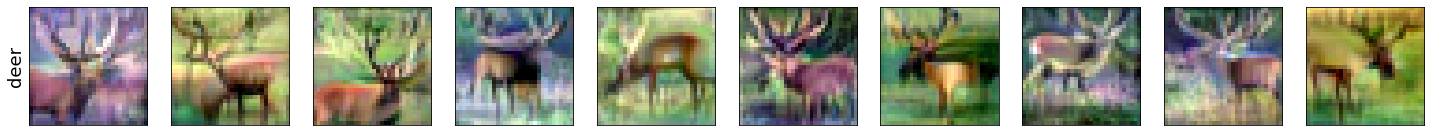

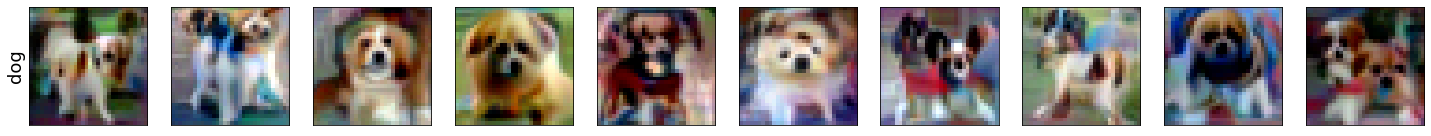

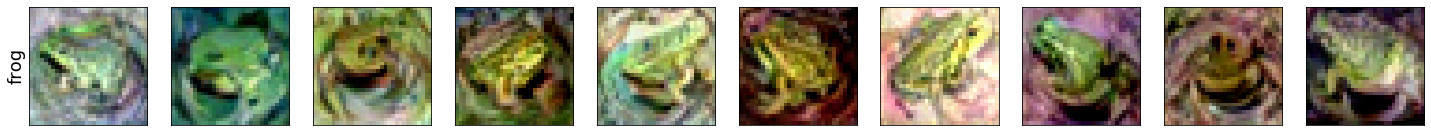

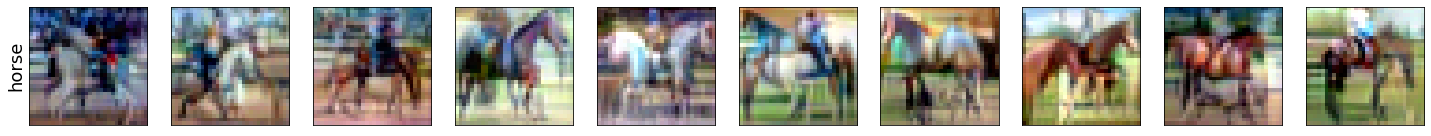

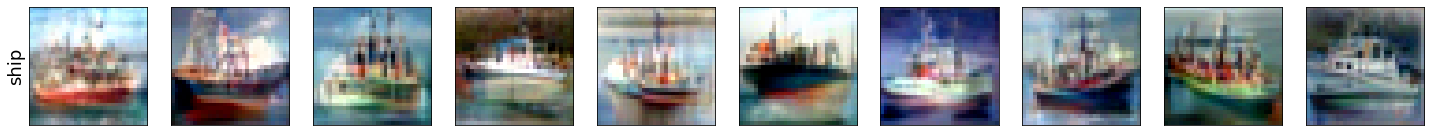

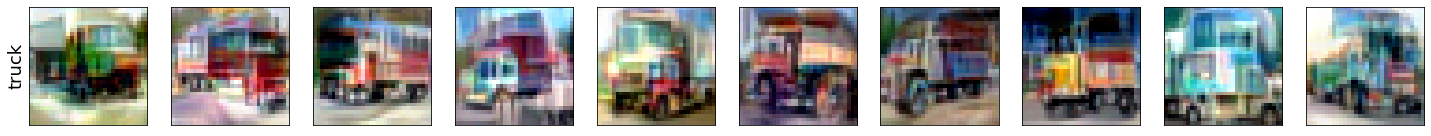

In [11]:
show_seed = False
for i in range(NUM_CLASSES_VIS):
    target_class = i * ch.ones((BATCH_SIZE, )) 
    im_seed = ch.stack([conditionals[int(t)].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
                        for t in target_class])
    
    im_seed = upsample(ch.clamp(im_seed, min=0, max=1))
    _, im_gen = model(im_seed, target_class.long(), make_adv=True, **kwargs)
    if show_seed:
        show_image_row([im_seed.cpu()], [f'Seed ($x_0$)'], fontsize=18)
    show_image_row([im_gen.detach().cpu()], 
                   [CLASSES[int(t)].split(',')[0] for t in target_class], 
                   fontsize=18)

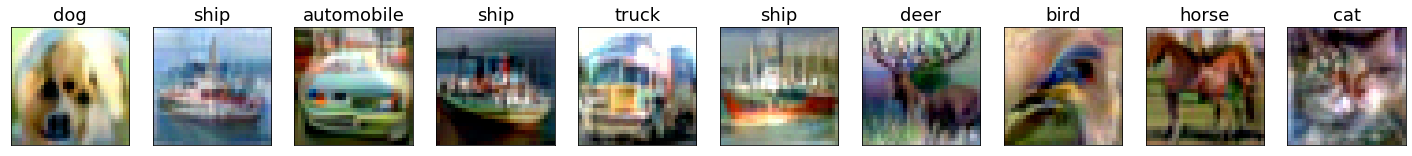

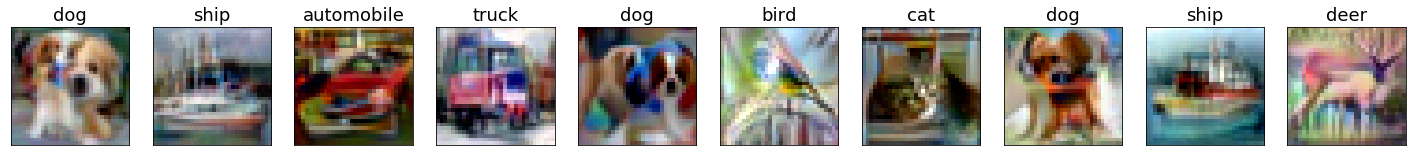

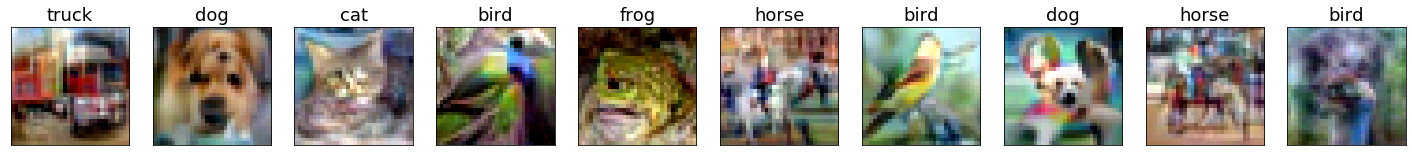

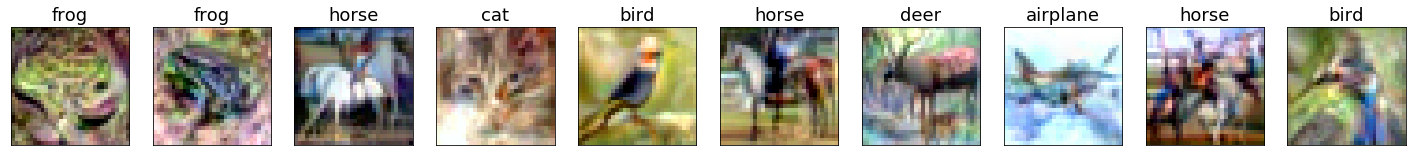

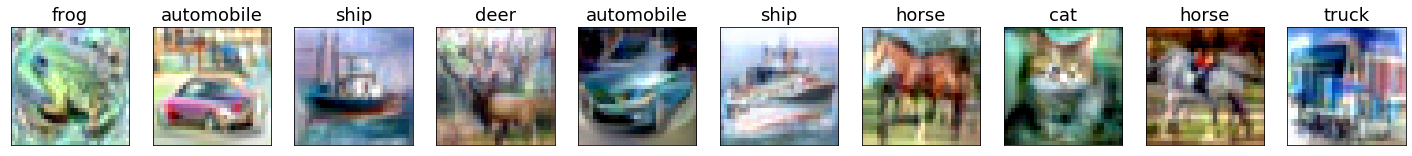

In [10]:
show_seed = False
for i in range(5):
    target_class = ch.tensor(np.random.choice(range(NUM_CLASSES_VIS), (BATCH_SIZE,)))
    im_seed = ch.stack([conditionals[int(t)].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
                        for t in target_class])
    
    im_seed = upsample(ch.clamp(im_seed, min=0, max=1))
    _, im_gen = model(im_seed, target_class.long(), make_adv=True, **kwargs)
    if show_seed:
        show_image_row([im_seed.cpu()], [f'Seed ($x_0$)'], fontsize=18)
    show_image_row([im_gen.detach().cpu()], 
                   tlist=[[CLASSES[int(t)].split(',')[0] for t in target_class]], 
                   fontsize=18)